In [50]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


/home/dracdarktime/miniconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


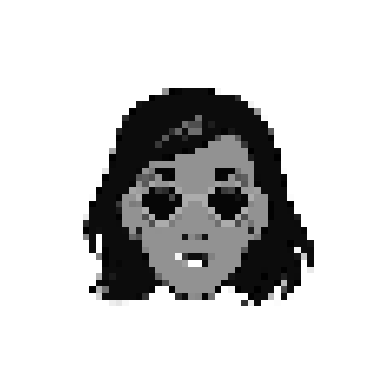

In [51]:
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import generacion_cartoon.utils.paths as path
import notebooks.drac_CNVAE_gradient as CNVAE
import generacion_cartoon.visualization.visualize_CNVAE as visualize 
import tensorflow as tf
import time
import numpy as np

In [66]:
import tensorflow as tf

print("TensorFlow versión:", tf.__version__)
print("¿TensorFlow usa CUDA?:", tf.test.is_built_with_cuda())
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
print("Dispositivo GPU:", tf.test.gpu_device_name())


TensorFlow versión: 2.18.0
¿TensorFlow usa CUDA?: True
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dispositivo GPU: /device:GPU:0


I0000 00:00:1747713955.633095  390097 gpu_device.cc:2022] Created device /device:GPU:0 with 4803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [67]:
import mlflow
import dagshub

In [ ]:
params ={'latent_dim':90,
 'epochs':30,
 'epsilon':0.001, 
 'beta':0.1} 


model = CNVAE.CNVAE(latent_dim=params['latent_dim'], beta=params['beta'])

In [69]:
name_model = f'model_FCNVAE__dim{params["latent_dim"]}_epocs={params["epochs"]}_epsilon={params["epsilon"]}_beta={params["beta"]}_.weights.h5'
path_models = path.models_dir(name_model)

In [70]:
model.summary()


Encoder Summary:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 27, 27, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 90)             │       973,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,346 (3.79 MB)

 Trainable params: 992,346 (3.79 MB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 4900)           │       445,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 7, 7, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_36             │ (None, 14, 14, 128)    │       115,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 56, 56, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,597 (2.42 MB)

 Trainable params: 635,597 (2.42 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 1,627,943


In [65]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
mlflow.set_experiment("FCNVAE_dim_beta")
mlflow.start_run()
mlflow.log_params(params)

optimizer = tf.keras.optimizers.Adam(params['epsilon'])
model.build(input_shape=(None, 56, 56, 1))
model.compile(params=params,
                    train_ds = train_ds,
                    test_ds=None,
                    patience=10,
                    optimizer=optimizer,
                    path_models=path_models)

mlflow.tensorflow.log_model(model, 'model')        
mlflow.end_run()
#name_gif = f'grid_CNVAE_epochs={params["epochs"]}_epsilon{params["epsilon"]}_alpha={params["alpha"]}_beta{params["beta"]}_gamma{params["gamma"]}.gif'
#visualize.create_gif(name_gif=name_gif, path_save_gif=path.data_created_dir('cnvae'))


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
mlflow.end_run()

🏃 View run glamorous-carp-608 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11/runs/1d17f4f974ec4a5fa2add0544e815306
🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/11


In [60]:
model.load_weights(path_models)

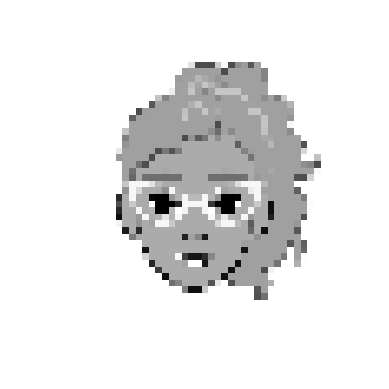

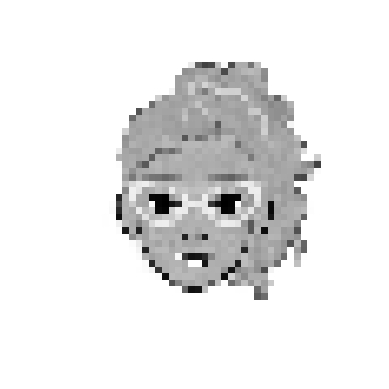

In [61]:
visualize.plot_img_original_generated(model=model,num_img=20,test_ds=test_ds)

In [27]:
#visualize.plot_latent_images(model=model, num_images_x= 20, epoch=2, stan_des= 1, mean=0)